In [1]:
using GaussianDistributions
using CovarianceFunctions
using LinearAlgebra
using Plots

Suppose that we are given a dataset $D = \{(\textbf{x}_1, y_1), ... , (\textbf{x}_n, y_n)\}$ consisting of three
observations, and we wish now to only consider functions that pass through these two data points exactly.
Here, our objective function is
$$\begin{aligned}
-sin(3x) -x^2 + .7x
\end{aligned}$$
and our samples are likely to be tainted by gaussian noise. We define our function as follows, along with 3 samples $\in [-1, 2]$. 

In [51]:
noise = .1

function f(x; σnoise=noise)
    return -sin(3*x) - x^2 + .7x + σnoise*randn()
end

sample_noise = 0.0
X_init = [-.9, 0., 0.5, 1.2, 1.7]
Y_init = f.(X_init, σnoise=sample_noise)

5-element Array{Float64,1}:
 -1.0126201197661704
  0.0
 -0.8974949866040546
 -0.1574795567051479
 -0.7741853176722673

If we were to densely sample the function above, we'd see clearly that the function is smooth from $[-1, 2]$.

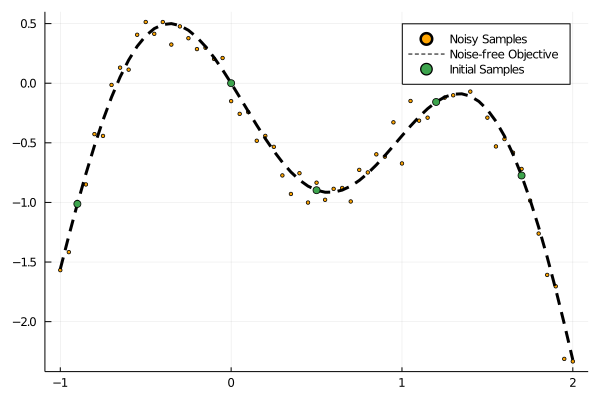

In [52]:
# Dense grid of points within bounds
bounds = -1:.05:2
X = collect(bounds)

# Noise-free objective function values at X
Y = f.(X, σnoise=0.)

# Plot noise-free optimization objective alongside noisy objective
scatter(X, f.(X), ms=2, label="Noisy Samples", color="orange")
plot!(X, Y, ls=:dash, lw=3, label="Noise-free Objective", color="black")
scatter!(X_init, Y_init, label="Initial Samples")

Now that we've sampled from our `unknown` process, we'd like to initialize our model and specify a covariance function for our Gaussian Process. For our covariance function, let's go with the Gaussian CovarianceFunctions. For our mean function, zero.

In [57]:
# Note that K == Σ, but we'll leverage Kernels.jl
ℓ = 1.
μ(x) = zero(x)
Σ(x, y) = CovarianceFunctions.Lengthscale(CovarianceFunctions.EQ(), ℓ)(x, y)
K(x, y) = exp(-norm(x - y)^2/(2ℓ^2))
x, y = rand(5), rand(5)
@assert K(x, y) ≈ Σ(x, y)

GP = Gaussian(μ, Σ)

Gaussian{typeof(μ),typeof(Σ)}(μ, Σ)

Once we've initialized our model, the next natural step is to condition our GP on observations. Thanks to the expressivity of Julia and some syntactic sugar,
our conditional GP in code resembles what one might see in math.

In [54]:
CGP = GP | (X_init, Y_init, sample_noise);

Now that we've conditioned our GP on our observations, let's plot the mean and pointwise variance to get a visual representation of our newly learned distribution
of functions.

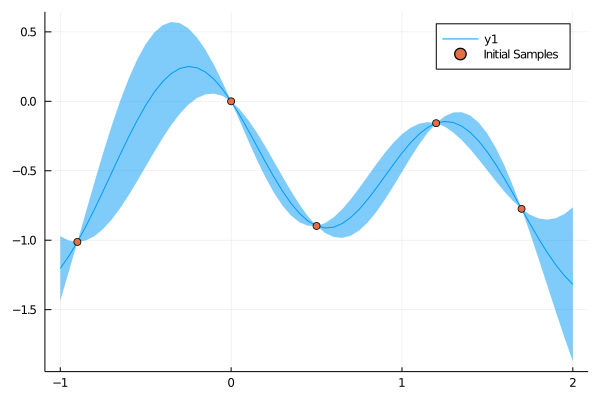

In [55]:
μ̂ = mean(CGP)
σ̂ = std(CGP)
plot(X, μ̂.(X), ribbon=2σ̂.(X))
scatter!(X_init, Y_init, label="Initial Samples")

Observe the graphs side by side

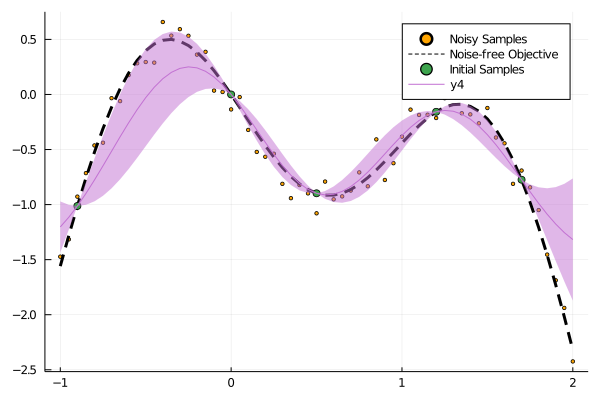

In [56]:
# Plot noise-free optimization objective alongside noisy objective
scatter(X, f.(X), ms=2, label="Noisy Samples", color="orange")
plot!(X, Y, ls=:dash, lw=3, label="Noise-free Objective", color="black")
scatter!(X_init, Y_init, label="Initial Samples")
plot!(X, μ̂.(X), ribbon=2σ̂.(X))

Relerr: 0.02304986861063152


-0.11679063335112594